In [66]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [67]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
pip install --upgrade openpyxl


   ---------------------------------------- 0.0/250.9 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/250.9 kB 1.3 MB/s eta 0:00:01
   ------ -------------------------------- 41.0/250.9 kB 653.6 kB/s eta 0:00:01
   -------------- ------------------------ 92.2/250.9 kB 744.7 kB/s eta 0:00:01
   ------------------ ------------------- 122.9/250.9 kB 798.9 kB/s eta 0:00:01
   ----------------------------- -------- 194.6/250.9 kB 980.4 kB/s eta 0:00:01
   ---------------------------------------  245.8/250.9 kB 1.1 MB/s eta 0:00:01
   -------------------------------------- 250.9/250.9 kB 904.8 kB/s eta 0:00:00
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 3.0.10
    Uninstalling openpyxl-3.0.10:
      Successfully uninstalled openpyxl-3.0.10


Time Series Data Analysis

Epoch 1/200
25/25 [==============================] - 3s 21ms/step - loss: 0.3448 - mae: 0.4991 - val_loss: 0.0469 - val_mae: 0.1643
Epoch 2/200
25/25 [==============================] - 0s 7ms/step - loss: 0.0718 - mae: 0.2070 - val_loss: 0.0237 - val_mae: 0.1305
Epoch 3/200
25/25 [==============================] - 0s 8ms/step - loss: 0.0488 - mae: 0.1677 - val_loss: 0.0180 - val_mae: 0.1208
Epoch 4/200
25/25 [==============================] - 0s 8ms/step - loss: 0.0381 - mae: 0.1534 - val_loss: 0.0152 - val_mae: 0.1095
Epoch 5/200
25/25 [==============================] - 0s 6ms/step - loss: 0.0372 - mae: 0.1464 - val_loss: 0.0262 - val_mae: 0.1508
Epoch 6/200
25/25 [==============================] - 0s 5ms/step - loss: 0.0312 - mae: 0.1350 - val_loss: 0.0238 - val_mae: 0.1410
Epoch 7/200
25/25 [==============================] - 0s 6ms/step - loss: 0.0293 - mae: 0.1318 - val_loss: 0.0270 - val_mae: 0.1512
Epoch 8/200
25/25 [==============================] - 0s 6ms/step - loss: 0.0251 - 

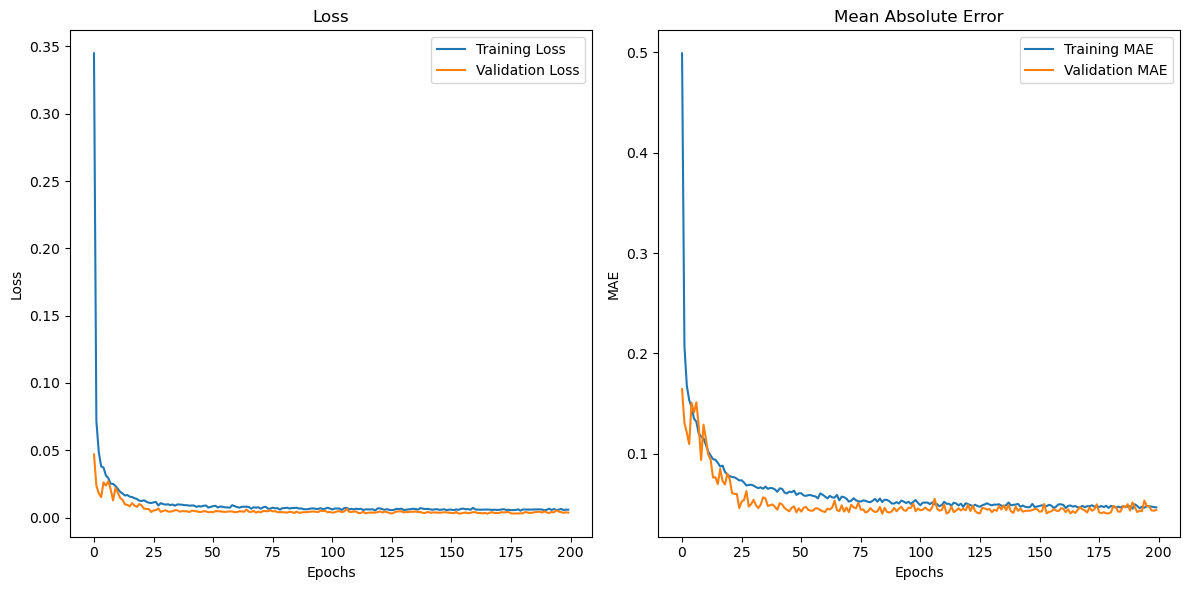

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout


NUM_QUBITS = 8  
NUM_SAMPLES = 100
SHOTS = 1024

def load_mackey_glass_data(filepath):
    df = pd.read_excel(filepath)
    return df['t'].values, df['t-taw'].values, df['t+1'].values

def lif_dynamics(x_t, v_prev, alpha=0.9, W=1.0, omega=0.5, k=5.0):
    v_t = alpha * v_prev + W * x_t
    mu_t = 1 if v_t > omega else 0
    if mu_t == 1:
        lam = k * abs(x_t)
        N_spikes = np.random.poisson(lam)
        inter_times = np.random.exponential(1 / (lam + 1e-6), N_spikes)
        spike_times = np.cumsum(inter_times)
        spike_amplitudes = np.random.poisson(lam, N_spikes)
        return spike_times, spike_amplitudes
    return [], []

def bin_spikes(spike_times, spike_amplitudes, Q):
    if len(spike_times) == 0:
        return np.zeros(Q), np.zeros(Q)
    max_t = np.max(spike_times)
    bin_indices = np.floor(Q * spike_times / (max_t + 1e-6)).astype(int)
    bin_indices = np.clip(bin_indices, 0, Q - 1)

    a = np.zeros(Q)
    tau = np.zeros(Q)

    for i in range(Q):
        bin_times = spike_times[bin_indices == i]
        bin_amps = spike_amplitudes[bin_indices == i]
        if len(bin_amps) > 0:
            a[i] = np.mean(bin_amps)
            tau[i] = np.mean(bin_times)
    a = np.pi * a / (np.max(a) + 1e-6)
    tau = 2 * np.pi * tau / (np.max(tau) + 1e-6)
    return a, tau

def quantum_encode(amplitudes, times, apply_entangle=True):
    qc = QuantumCircuit(NUM_QUBITS)
    qc.h(range(NUM_QUBITS))  # Apply Hadamard to all

    for j in range(NUM_QUBITS):
        amp = amplitudes[j] if j < len(amplitudes) else 0
        phi = times[j] if j < len(times) else 0
        qc.u(amp, phi, -phi, j)

    if apply_entangle:
        for j in range(NUM_QUBITS - 1):
            qc.cx(j, j + 1)
    return qc

def apply_variational_layer(qc, params):
    for j in range(NUM_QUBITS):
        qc.ry(params[j], j)
        qc.rz(params[j + NUM_QUBITS], j)
    return qc

def get_measurement_vector(qc, shots=SHOTS):
    qc.measure_all()
    backend = Aer.get_backend('aer_simulator')
    result = execute(qc, backend, shots=shots).result()
    counts = result.get_counts()
    vec = np.array([counts.get(bin(i)[2:].zfill(NUM_QUBITS), 0) for i in range(2 ** NUM_QUBITS)])
    return vec / np.sum(vec)

def encode_sample(x_t, Q=NUM_QUBITS, theta=None):
    v = 0
    spikes, times = lif_dynamics(x_t, v)
    a, tau = bin_spikes(np.array(times), np.array(spikes), Q)
    qc = quantum_encode(a, tau)

    if theta is None:
        theta = np.random.uniform(0, 2 * np.pi, 2 * Q)
    qc = apply_variational_layer(qc, theta)

    return get_measurement_vector(qc)

def build_hybrid_model(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(64, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(1)(x)
    model = Model(inputs, output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def main():
    t, t_taw, t_plus_1 = load_mackey_glass_data("C:\\Users\\riakh\\Downloads\\archive (13)\\Mackey-Glass Time Series(taw17).xlsx")
    t_norm = (t - np.min(t)) / (np.max(t) - np.min(t))
    t_taw_norm = (t_taw - np.min(t_taw)) / (np.max(t_taw) - np.min(t_taw))
    
    features = []
    targets = []
    for xt, yt in zip(t_taw_norm[:-1], t_plus_1[:-1]):
        encoded = encode_sample(xt)
        features.append(encoded)
        targets.append(yt)

    X = np.array(features)
    y = np.array(targets)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = build_hybrid_model(X.shape[1])
    history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, verbose=1)

    test_loss, test_mae = model.evaluate(X_test, y_test)
    print("Test Loss:", test_loss, "Test MAE:", test_mae)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Train")
    plt.plot(history.history["val_loss"], label="Val")
    plt.title("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["mae"], label="Train MAE")
    plt.plot(history.history["val_mae"], label="Val MAE")
    plt.title("MAE")
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Epoch 1/100
82/82 [==============================] - 1s 4ms/step - loss: 0.1079 - mae: 0.2826 - val_loss: 0.0306 - val_mae: 0.1403 - lr: 0.0010
Epoch 2/100
82/82 [==============================] - 0s 2ms/step - loss: 0.0187 - mae: 0.1061 - val_loss: 0.0119 - val_mae: 0.0879 - lr: 0.0010
Epoch 3/100
82/82 [==============================] - 0s 2ms/step - loss: 0.0118 - mae: 0.0845 - val_loss: 0.0104 - val_mae: 0.0823 - lr: 0.0010
Epoch 4/100
82/82 [==============================] - 0s 2ms/step - loss: 0.0109 - mae: 0.0815 - val_loss: 0.0104 - val_mae: 0.0825 - lr: 0.0010
Epoch 5/100
82/82 [==============================] - 0s 2ms/step - loss: 0.0110 - mae: 0.0818 - val_loss: 0.0105 - val_mae: 0.0828 - lr: 0.0010
Epoch 6/100
82/82 [==============================] - 0s 3ms/step - loss: 0.0110 - mae: 0.0820 - val_loss: 0.0104 - val_mae: 0.0825 - lr: 0.0010
Epoch 7/100
82/82 [==============================] - 0s 2ms/step - loss: 0.0111 - mae: 0.0819 - val_loss: 0.0105 - val_mae: 0.0828 - lr:

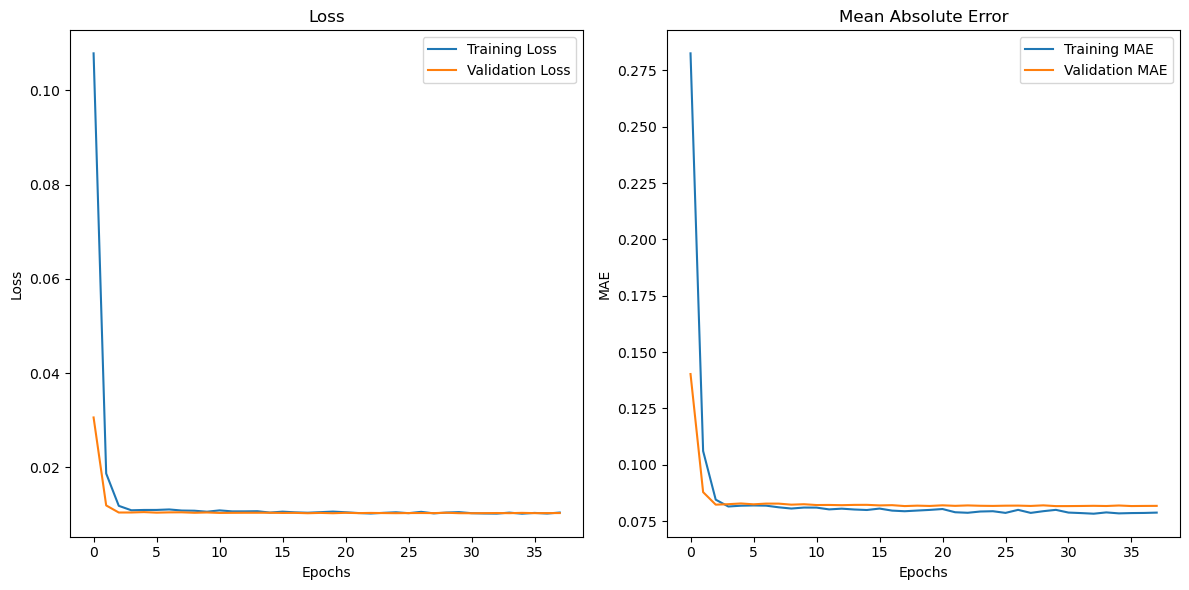

In [ ]:
def load_temperature_data(filepath):
    df = pd.read_csv(filepath, parse_dates=['Date'], dayfirst=True)
    df['Daily minimum temperatures'] = pd.to_numeric(df['Daily minimum temperatures'], errors='coerce')
    df.dropna(inplace=True)
    return df['Daily minimum temperatures'].values

def lif_dynamics(x_t, v_prev, alpha=0.9, W=1.0, omega=0.5, k=5.0):
    v_t = alpha * v_prev + W * x_t
    mu_t = 1 if v_t > omega else 0
    if mu_t == 1:
        lam = k * abs(x_t)
        N_spikes = np.random.poisson(lam)
        inter_times = np.random.exponential(1 / (lam + 1e-6), N_spikes)
        spike_times = np.cumsum(inter_times)
        spike_amplitudes = np.random.poisson(lam, N_spikes)
        return spike_times, spike_amplitudes
    return [], []


def bin_spikes(spike_times, spike_amplitudes, Q):
    if len(spike_times) == 0:
        return np.zeros(Q), np.zeros(Q)
    max_t = np.max(spike_times)
    bin_indices = np.floor(Q * spike_times / (max_t + 1e-6)).astype(int)
    bin_indices = np.clip(bin_indices, 0, Q - 1)

    a = np.zeros(Q)
    tau = np.zeros(Q)

    for i in range(Q):
        bin_times = spike_times[bin_indices == i]
        bin_amps = spike_amplitudes[bin_indices == i]
        if len(bin_amps) > 0:
            a[i] = np.mean(bin_amps)
            tau[i] = np.mean(bin_times)

    a = np.pi * a / (np.max(a) + 1e-6)
    tau = 2 * np.pi * tau / (np.max(tau) + 1e-6)
    return a, tau


def quantum_encode(amplitudes, times):
    qc = QuantumCircuit(NUM_QUBITS)
    qc.h(range(NUM_QUBITS))

    for j in range(NUM_QUBITS):
        amp = amplitudes[j] if j < len(amplitudes) else 0
        phi = times[j] if j < len(times) else 0
        qc.u(amp, phi, -phi, j)

    return qc


def apply_vqc_layer(qc, params):
    for j in range(NUM_QUBITS):
        qc.ry(params[j], j)
        qc.rz(params[j + NUM_QUBITS], j)
        
    for j in range(NUM_QUBITS - 1):
        qc.cx(j, j + 1)

    return qc


def get_measurement_vector(qc, shots=SHOTS):
    qc.measure_all()
    backend = Aer.get_backend('aer_simulator')
    result = execute(qc, backend, shots=shots).result()
    counts = result.get_counts()
    vec = np.array([counts.get(bin(i)[2:].zfill(NUM_QUBITS), 0) for i in range(2 ** NUM_QUBITS)])
    return vec / np.sum(vec)

def encode_sample(x_t, Q=NUM_QUBITS, theta=None):
    v_prev = 0
    spike_times, spike_amps = lif_dynamics(x_t, v_prev)
    a, tau = bin_spikes(np.array(spike_times), np.array(spike_amps), Q)
    qc = quantum_encode(a, tau)

    if theta is None:
        theta = np.random.uniform(0, 2 * np.pi, 2 * Q)

    qc = apply_vqc_layer(qc, theta)
    return get_measurement_vector(qc)

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, activation='relu', input_shape=input_shape),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def main():
    filepath = "C:\\Users\\riakh\\Downloads\\daily-minimum-temperatures-in-me.csv"
    temps = load_temperature_data(filepath)

    scaler = MinMaxScaler()
    temps_scaled = scaler.fit_transform(temps.reshape(-1, 1)).flatten()

    features = []
    targets = []
    for i in range(len(temps_scaled) - 1):
        encoded = encode_sample(temps_scaled[i])
        features.append(encoded)
        targets.append(temps_scaled[i + 1])

    X = np.array(features).reshape(-1, 1, 2 ** NUM_QUBITS)
    y = np.array(targets)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

    history = model.fit(X_train, y_train, validation_split=0.1, epochs=100,
                        callbacks=[early_stop, reduce_lr], verbose=1)

    loss, mae = model.evaluate(X_test, y_test)
    print(f"Test Loss: {loss:.4f} | Test MAE: {mae:.4f}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Train")
    plt.plot(history.history["val_loss"], label="Val")
    plt.title("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["mae"], label="Train MAE")
    plt.plot(history.history["val_mae"], label="Val MAE")
    plt.title("MAE")
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Epoch 1/100
29/29 [==============================] - 1s 8ms/step - loss: 0.3429 - mae: 0.5429 - val_loss: 0.2699 - val_mae: 0.4709
Epoch 2/100
29/29 [==============================] - 0s 2ms/step - loss: 0.2037 - mae: 0.3951 - val_loss: 0.1327 - val_mae: 0.3025
Epoch 3/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0879 - mae: 0.2326 - val_loss: 0.0470 - val_mae: 0.1763
Epoch 4/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0317 - mae: 0.1453 - val_loss: 0.0171 - val_mae: 0.1134
Epoch 5/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0133 - mae: 0.0933 - val_loss: 0.0056 - val_mae: 0.0606
Epoch 6/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0058 - mae: 0.0578 - val_loss: 0.0018 - val_mae: 0.0289
Epoch 7/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0044 - mae: 0.0486 - val_loss: 0.0010 - val_mae: 0.0220
Epoch 8/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0040 - m

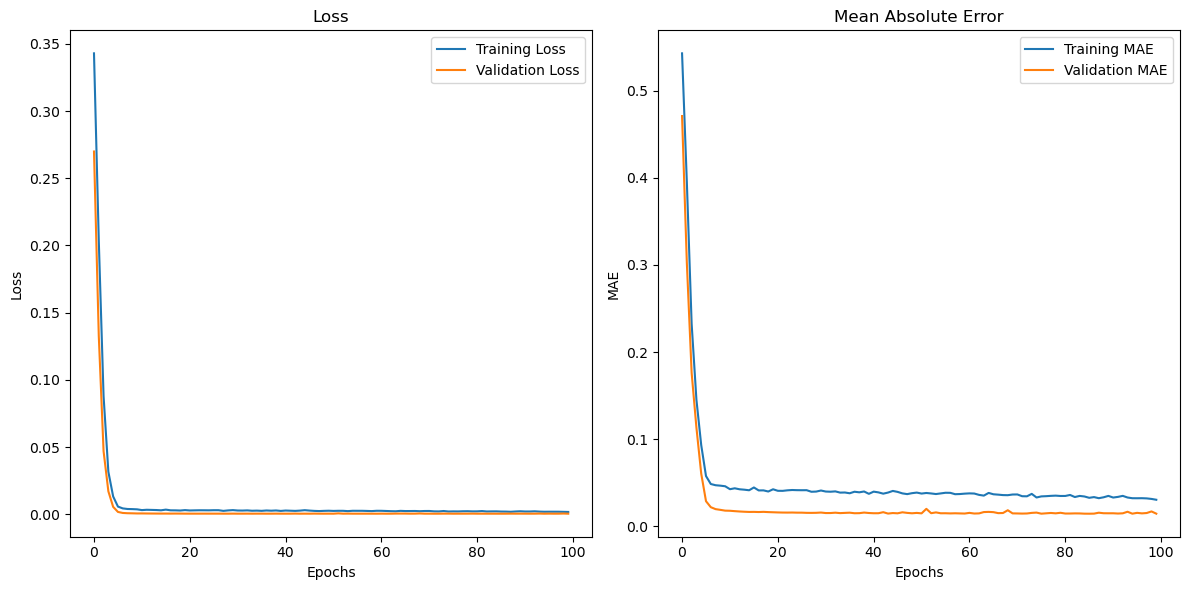

In [ ]:

def load_finance_data(filepath):
    df = pd.read_excel(filepath, parse_dates=['Date'])
    if df['Close*'].dtype == 'object':
        df['Close*'] = pd.to_numeric(df['Close*'].str.replace(',', ''), errors='coerce')
    else:
        df['Close*'] = pd.to_numeric(df['Close*'], errors='coerce')
    df.dropna(subset=['Close*'], inplace=True)
    return df['Close*'].values


def lif_dynamics(x_t, v_prev, alpha=0.9, W=1.0, omega=0.5, k=5.0):
    v_t = alpha * v_prev + W * x_t
    mu_t = 1 if v_t > omega else 0
    if mu_t:
        lam = k * abs(x_t)
        N_spikes = np.random.poisson(lam)
        inter_times = np.random.exponential(1 / (lam + 1e-6), N_spikes)
        spike_times = np.cumsum(inter_times)
        spike_amplitudes = np.random.poisson(lam, N_spikes)
        return spike_times, spike_amplitudes
    return [], []

def bin_spikes(spike_times, spike_amps, Q):
    if len(spike_times) == 0:
        return np.zeros(Q), np.zeros(Q)
    max_t = np.max(spike_times)
    bin_indices = np.floor(Q * spike_times / (max_t + 1e-6)).astype(int)
    bin_indices = np.clip(bin_indices, 0, Q - 1)
    a, tau = np.zeros(Q), np.zeros(Q)
    for i in range(Q):
        mask = bin_indices == i
        if np.any(mask):
            a[i] = np.mean(spike_amps[mask])
            tau[i] = np.mean(spike_times[mask])
    a = np.pi * a / (np.max(a) + 1e-6)
    tau = 2 * np.pi * tau / (np.max(tau) + 1e-6)
    return a, tau

# Single or double encoding
def quantum_encode(amplitudes, times=None, double_encoding=True):
    qc = QuantumCircuit(NUM_QUBITS)
    for j in range(NUM_QUBITS):
        amp = amplitudes[j] if j < len(amplitudes) else 0
        if double_encoding and times is not None:
            phi = times[j] if j < len(times) else 0
            qc.u(amp, phi, -phi, j)
        else:
            qc.rx(amp, j)
    return qc


def apply_vqc(qc, theta):
    for j in range(NUM_QUBITS):
        qc.ry(theta[j], j)
        qc.rz(theta[j + NUM_QUBITS], j)
    for j in range(NUM_QUBITS - 1):
        qc.cx(j, j + 1)
    return qc

def get_measurement_vector(qc):
    qc.measure_all()
    backend = Aer.get_backend('aer_simulator')
    result = execute(qc, backend, shots=SHOTS).result()
    counts = result.get_counts()
    vec = np.array([counts.get(bin(i)[2:].zfill(NUM_QUBITS), 0) for i in range(2 ** NUM_QUBITS)])
    return vec / np.sum(vec)


def encode_sample(x_t, double_encoding=True, theta=None):
    v = 0
    spikes, times = lif_dynamics(x_t, v)
    a, tau = bin_spikes(np.array(times), np.array(spikes), NUM_QUBITS)
    qc = quantum_encode(a, tau if double_encoding else None, double_encoding=double_encoding)
    if theta is None:
        theta = np.random.uniform(0, 2 * np.pi, 2 * NUM_QUBITS)
    qc = apply_vqc(qc, theta)
    return get_measurement_vector(qc)


def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, activation='relu', input_shape=input_shape),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def main():
    filepath = "C:\\Users\\riakh\\Downloads\\archive (14)\\yahoo_data.xlsx"
    close_values = load_finance_data(filepath)

    scaler = MinMaxScaler()
    close_values_normalized = scaler.fit_transform(close_values.reshape(-1, 1)).flatten()

    quantum_features, targets = [], []
    for i in range(len(close_values_normalized) - 1):
        encoded = encode_sample(close_values_normalized[i], double_encoding=True)  # Change to False for single
        quantum_features.append(encoded)
        targets.append(close_values_normalized[i + 1])

    X = np.array(quantum_features).reshape((-1, 1, 2**NUM_QUBITS))
    y = np.array(targets)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = build_lstm_model((X.shape[1], X.shape[2]))
    history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, verbose=1)

    loss, mae = model.evaluate(X_test, y_test)
    print("Test Loss:", loss, "Test MAE:", mae)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title('MAE')
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
